<h1>Titanic - Machine Learning from Disaster <h1>

Importing libraries:

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import sys
import xgboost as xgb
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
DROPOUT = 0.2
EPOCHS = 10


<h2>Data preprocessing and cleaning<h2>

Loading data and looking into it

Train data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Test data:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


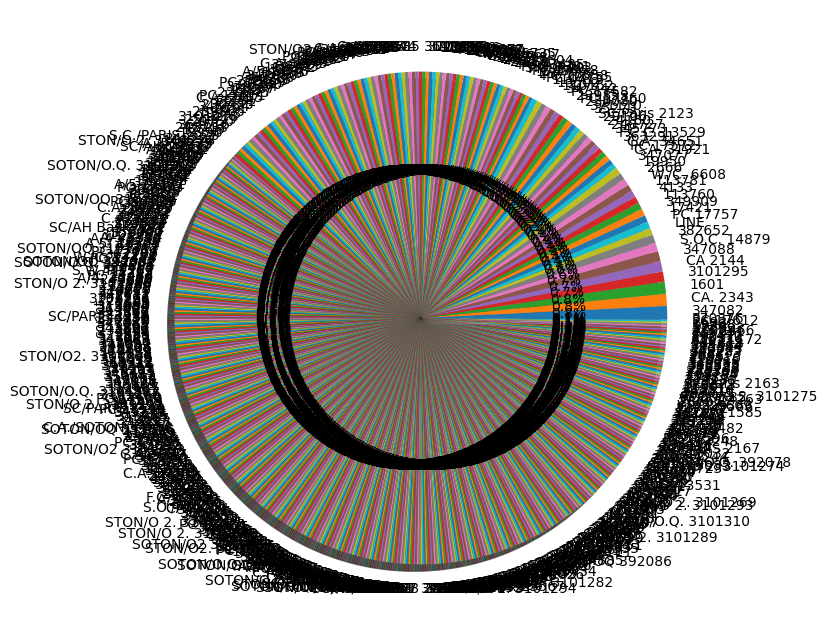

In [2]:

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


print("Train data:")
display(train_data.head(10))

print("Test data:")
display(test_data.head(10))

display(train_data.describe())






fig, ax = plt.subplots(figsize=(8, 8))
train_data["Ticket"].value_counts().plot.pie(autopct='%1.1f%%', ax=ax, shadow=True)
plt.show()


In [65]:
#PREPROCESSING DATA:
#1. dropping useless columns
train_x = train_data.drop(['Survived', 'Name',"PassengerId","Ticket","Cabin"], axis=1)

train_y = train_data["Survived"]

test_x = test_data.drop(['Name',"PassengerId","Ticket","Cabin"], axis=1)

#2. applying one-hot encoding

combined_trainTest = pd.concat([train_x, test_x], ignore_index=True)

#One-hot encoding some columns and leaving some out
to_hp = ['Sex', 'Pclass', 'Embarked']
to_not_hp = ['SibSp', 'Parch',"Age"]

#Applying one-hot encoding to categorical columns
categorical_data_train = pd.get_dummies(combined_trainTest[to_hp])

# Combining one-hot encoded categorical columns with numerical columns
combinedFiltered = pd.concat([categorical_data_train, combined_trainTest[to_not_hp]], axis=1)

#split them back
train_x = combinedFiltered[:len(train_data)]
test_x = combinedFiltered[len(train_data):]

#3. fill missing values
train_x = train_x.fillna(train_x.mean())
test_x = test_x.fillna(test_x.mean())

#4. normalize

train_x = (train_x - train_x.mean()) / train_x.std()
test_x = (test_x - test_x.mean()) / test_x.std()


train_x.tail(20)

,Pclass,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,SibSp,Parch,Age
871,-1.565228,1.354813,-1.354813,-0.481772,-0.307390,0.618959,0.432550,0.767199,1.330631
872,-1.565228,-0.737281,0.737281,-0.481772,-0.307390,0.618959,-0.474279,-0.473408,0.253875
873,0.826913,-0.737281,0.737281,-0.481772,-0.307390,0.618959,-0.474279,-0.473408,1.330631
874,-0.369158,1.354813,-1.354813,2.073341,-0.307390,-1.613803,0.432550,-0.473408,-0.130681
875,0.826913,1.354813,-1.354813,2.073341,-0.307390,-1.613803,-0.474279,-0.473408,-1.130526
876,0.826913,-0.737281,0.737281,-0.481772,-0.307390,0.618959,-0.474279,-0.473408,-0.745970
877,0.826913,-0.737281,0.737281,-0.481772,-0.307390,0.618959,-0.474279,-0.473408,-0.822881
878,0.826913,-0.737281,0.737281,-0.481772,-0.307390,0.618959,-0.474279,-0.473408,0.000000
879,-1.565228,1.354813,-1.354813,2.073341,-0.307390,-1.613803,-0.474279,0.767199,2.022831
880,-0.369158,1.354813,-1.354813,-0.481772,-0.307390,0.618959,-0.474279,0.767199,-0.361415


<h2>Training using xgboost - boosted random forest algorithm<h2>

<h4>Defining parameters<h4>

In [68]:
#Set the best parameters possible for this data
params = {

'objective': 'binary:logistic',
'eval_metric': 'logloss',
'eta': 0.3,
'max_depth': 9,
'min_child_weight': 0.5,
'gamma': 0.015,
'subsample': 0.87,
'colsample_bytree': 0.9,
'tree_method': 'exact',
'seed': 40

}

# Set threshold for classification
threshold = 0.5  # Adjust the threshold as desired

<h3>Train the model and add the predictions do a csv file<h3>

In [69]:
def main():

    dtrain = xgb.DMatrix(train_x, label=train_y)
    model = xgb.train(params, dtrain, num_boost_round=170, evals=[(dtrain, 'train')])
    

    # Convert new data to DMatrix format
    new_data = xgb.DMatrix(test_x)

# Make predictions on the new data
    predictions = model.predict(new_data)


# Convert probabilities to binary predictions
    predictions_binary = [1 if pred >= threshold else 0 for pred in predictions]

    output_data = pd.DataFrame({
    'PassengerId': range(892, 1310),
    'Survived': predictions_binary
})
    
    training_cost = model.eval(dtrain)
    print("Training set cost (log loss):", training_cost)
    
# Save the predictions to a CSV file
    output_data.to_csv('predictions.csv', index=False)
    print("Predicted!")



if __name__ == "__main__":
    main()



[0]	train-logloss:0.57401
[1]	train-logloss:0.48594
[2]	train-logloss:0.42986
[3]	train-logloss:0.39338
[4]	train-logloss:0.37597
[5]	train-logloss:0.35599
[6]	train-logloss:0.34127
[7]	train-logloss:0.32809
[8]	train-logloss:0.31573
[9]	train-logloss:0.30629
[10]	train-logloss:0.29512
[11]	train-logloss:0.28981
[12]	train-logloss:0.28133
[13]	train-logloss:0.27677
[14]	train-logloss:0.26892
[15]	train-logloss:0.26571
[16]	train-logloss:0.26412
[17]	train-logloss:0.25755
[18]	train-logloss:0.25666
[19]	train-logloss:0.25054
[20]	train-logloss:0.24730
[21]	train-logloss:0.24420
[22]	train-logloss:0.24315
[23]	train-logloss:0.23891
[24]	train-logloss:0.23603
[25]	train-logloss:0.23422
[26]	train-logloss:0.22923
[27]	train-logloss:0.22793
[28]	train-logloss:0.22727
[29]	train-logloss:0.22500
[30]	train-logloss:0.22229
[31]	train-logloss:0.22008
[32]	train-logloss:0.21785
[33]	train-logloss:0.21598
[34]	train-logloss:0.21417
[35]	train-logloss:0.21211
[36]	train-logloss:0.20991
[37]	train-